In [48]:
import pandas as pd
import numpy as np
import os
#from PIL.Image import core
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense


In [40]:
#Import labels
l1 = pd.read_csv('label_map.txt', delim_whitespace=True, names=['Plankton', 'Index_number'])
l1.set_index(['Index_number'], inplace=True)

#Import train labels
train_labels = pd.read_csv('train_onelabel.csv')


In [43]:
#Paths of imagery
train_data_path = 'data/train_images'
test_data_path = 'data/test_images'

In [44]:
#Add label names to train_labels
labels = pd.merge(train_labels, l1, how='outer', left_on='class', right_index=True, copy=True)

In [28]:
print(labels.head())

print(labels['Plankton'].iloc[90:93])


len(labels['Plankton'])


                               Plankton
Index_number                           
0                  unknown_unclassified
1                        unknown_sticks
2                          protist_star
3             copepod_cyclopoid_oithona
4              hydromedusae_solmundella
Index_number
90     trochophore_larvae
91        shrimp_caridean
92    hydromedusae_shapeB
Name: Plankton, dtype: object


121

In [47]:
#train_labels.describe()
#train_labels.info()
select = labels['class'] == 6
labels[select].head()

,image,class,Plankton
1543,119571.jpg,6,echinoderm_larva_seastar_bipinnaria
1544,97318.jpg,6,echinoderm_larva_seastar_bipinnaria
1545,122571.jpg,6,echinoderm_larva_seastar_bipinnaria
1546,126560.jpg,6,echinoderm_larva_seastar_bipinnaria
1547,27538.jpg,6,echinoderm_larva_seastar_bipinnaria


In [8]:
#Only run first time
#os.mkdir('data/train_preprocessed')
#os.mkdir('data/test_preprocessed')
#Paths of imagery
train_data_path = 'data/train_images'
train_preprocessed_path = 'data/train_preprocessed'
test_data_path = 'data/test_images'
test_preprocessed_path = 'data/test_preprocessed'

In [62]:
#List directory with train imagery
train_data_listing = os.listdir(train_data_path)
print('Number of train images:', len(train_data_listing))

Number of train images: 24204


In [63]:
#Set image dimensions
img_rows = 224
img_cols = 224

In [56]:
#Resize images to 224x224 and add to path 'data/train_preprocessed'
for file in train_data_listing:
    im = Image.open(train_data_path + '\\' + file)
    img = im.resize((img_rows, img_cols))
    img.save(train_preprocessed_path + '\\' +file, 'JPEG')

In [57]:
#List directory with train imagery
test_data_listing = os.listdir(test_data_path)
print('Number of train images:', len(test_data_listing))

Number of train images: 6132


In [58]:
#Resize images to 224x224 and add to path 'data/test_preprocessed'
for file in test_data_listing:
    im = Image.open(test_data_path + '\\' + file)
    img = im.resize((img_rows, img_cols))
    img.save(test_preprocessed_path + '\\' +file, 'JPEG')

In [6]:
#List of plankton labels
plankton = list(labels['Plankton'])

In [9]:
train_batches = ImageDataGenerator().flow_from_directory(train_preprocessed_path, target_size=(224,224), classes=plankton, batch_size=10)

Found 0 images belonging to 121 classes.


In [10]:
#Set up training model
model = Sequential()


In [239]:
#class omzetten naar binair
#images labelen met binaire class

In [11]:
#Test
print(plankton[3])

copepod_cyclopoid_oithona


In [15]:
#From Kaggle
#Import libraries for doing image analysis
from skimage.io import imread
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier as RF
import glob
import os
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold as KFold
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from matplotlib import colors
from pylab import cm
from skimage import segmentation
from skimage.morphology import watershed
from skimage import measure
from skimage import morphology
import numpy as np
import pandas as pd
from scipy import ndimage
from skimage.feature import peak_local_max
# make graphics inline
%matplotlib inline


C:\ProgramData\Anaconda2\envs\py35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


data/train_preprocessed\100064.jpg


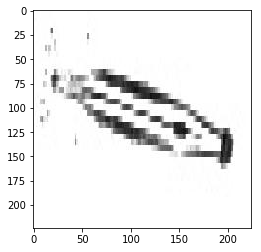

In [17]:
# Example image
# This example was chosen for because it has two noncontinguous pieces
# that will make the segmentation example more illustrative
example_file = glob.glob(os.path.join(train_preprocessed_path,"*.jpg"))[9]
print(example_file)
im = imread(example_file, as_grey=True)
plt.imshow(im, cmap=cm.gray)
plt.show()

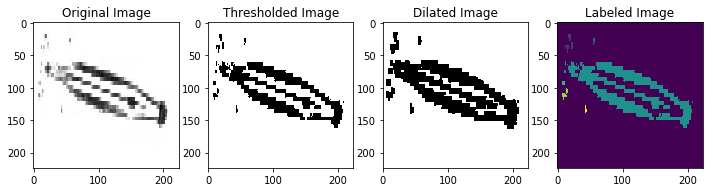

In [18]:
# First we threshold the image by only taking values greater than the mean to reduce noise in the image
# to use later as a mask
f = plt.figure(figsize=(12,3))
imthr = im.copy()
imthr = np.where(im > np.mean(im),0.,1.0)
sub1 = plt.subplot(1,4,1)
plt.imshow(im, cmap=cm.gray)
sub1.set_title("Original Image")

sub2 = plt.subplot(1,4,2)
plt.imshow(imthr, cmap=cm.gray_r)
sub2.set_title("Thresholded Image")

imdilated = morphology.dilation(imthr, np.ones((4,4)))
sub3 = plt.subplot(1, 4, 3)
plt.imshow(imdilated, cmap=cm.gray_r)
sub3.set_title("Dilated Image")

labels = measure.label(imdilated)
labels = imthr*labels
labels = labels.astype(int)
sub4 = plt.subplot(1, 4, 4)
sub4.set_title("Labeled Image")
plt.imshow(labels)

In [19]:
# calculate common region properties for each region within the segmentation
regions = measure.regionprops(labels)
# find the largest nonzero region
def getLargestRegion(props=regions, labelmap=labels, imagethres=imthr):
    regionmaxprop = None
    for regionprop in props:
        # check to see if the region is at least 50% nonzero
        if sum(imagethres[labelmap == regionprop.label])*1.0/regionprop.area < 0.50:
            continue
        if regionmaxprop is None:
            regionmaxprop = regionprop
        if regionmaxprop.filled_area < regionprop.filled_area:
            regionmaxprop = regionprop
    return regionmaxprop


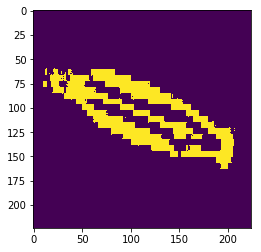

In [20]:
regionmax = getLargestRegion()
plt.imshow(np.where(labels == regionmax.label,1.0,0.0))
plt.show()

In [30]:
print(regionmax.minor_axis_length/regionmax.major_axis_length)


0.716532058423142


In [31]:
def getMinorMajorRatio(image):
    image = image.copy()
    # Create the thresholded image to eliminate some of the background
    imagethr = np.where(image > np.mean(image),0.,1.0)

    #Dilate the image
    imdilated = morphology.dilation(imagethr, np.ones((4,4)))

    # Create the label list
    label_list = measure.label(imdilated)
    label_list = imagethr*label_list
    label_list = label_list.astype(int)
    
    region_list = measure.regionprops(label_list)
    maxregion = getLargestRegion(region_list, label_list, imagethr)
    
    # guard against cases where the segmentation fails by providing zeros
    ratio = 0.0
    if ((not maxregion is None) and  (maxregion.major_axis_length != 0.0)):
        ratio = 0.0 if maxregion is None else  maxregion.minor_axis_length*1.0 / maxregion.major_axis_length
    return ratio

IndexError: list index out of range

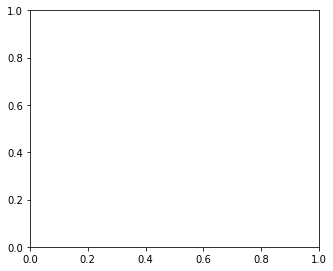

In [37]:
# Loop through the classes two at a time and compare their distributions of the Width/Length Ratio

#Create a DataFrame object to make subsetting the data on the class 
df = pd.DataFrame({"class": y[:], "ratio": X[:, num_features-1]})

f = plt.figure(figsize=(30, 20))
#we suppress zeros and choose a few large classes to better highlight the distributions.
df = df.loc[df["ratio"] > 0]
minimumSize = 20 
counts = df["class"].value_counts()
largeclasses = [int(x) for x in list(counts.loc[counts > minimumSize].index)]
# Loop through 40 of the classes 
for j in range(0,40,2):
    subfig = plt.subplot(4, 5, j/2 +1)
    # Plot the normalized histograms for two classes
    classind1 = largeclasses[j]
    classind2 = largeclasses[j+1]
    n, bins,p = plt.hist(df.loc[df["class"] == classind1]["ratio"].values,\
                         alpha=0.5, bins=[x*0.01 for x in range(100)], \
                         label=namesClasses[classind1].split(os.sep)[-1], normed=1)

    n2, bins,p = plt.hist(df.loc[df["class"] == (classind2)]["ratio"].values,\
                          alpha=0.5, bins=bins, label=namesClasses[classind2].split(os.sep)[-1],normed=1)
    subfig.set_ylim([0.,10.])
    plt.legend(loc='upper right')
    plt.xlabel("Width/Length Ratio")
